In [1]:
%pip install omegaconf
%pip install iopath
%pip install timm
%pip install decord
%pip install webdataset
%pip install einops
%pip install wandb
%pip install gradio
%pip install torchshow
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import argparse
import os
import random
import json
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchshow as ts
from timechat.common.config import Config
from timechat.common.dist_utils import get_rank
from timechat.common.registry import registry
from timechat.conversation.conversation_video import Chat, Conversation, default_conversation,SeparatorStyle, conv_llava_llama_2
import decord
import cv2
import time
import subprocess
from decord import VideoReader
from timechat.processors.video_processor import ToTHWC, ToUint8, load_video
decord.bridge.set_bridge('torch')

# imports modules for registration
from timechat.datasets.builders import *
from timechat.models import *
from timechat.processors import *
from timechat.runners import *
from timechat.tasks import *

import random as rnd
from transformers import StoppingCriteria, StoppingCriteriaList
from PIL import Image
import gradio as gr

/opt/conda/envs/timechat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='eval_configs/timechat.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=1)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--text-query", default="What is he doing?", help="question the video")
    parser.add_argument("--video-path", default='examples/padthai_2.mp4', help="path to video file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args

In [5]:
print('Initializing Chat')
args = parse_args()
cfg = Config(args)

DIR="ckpt/timechat"
MODEL_DIR=f"{DIR}/timechat_7b.pth"

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_config.ckpt = MODEL_DIR
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
model.eval()

vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

Initializing Chat
Loading VIT


INFO:root:freeze vision encoder


Loading VIT Done
Loading Q-Former
use text input for Qformer


INFO:root:load checkpoint from ckpt/instruct-blip/instruct_blip_vicuna7b_trimmed.pth
INFO:root:freeze Qformer
INFO:root:Loading Q-Former Done
INFO:root:Loading LLAMA Tokenizer
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Using pad_token, but it is not set yet.
INFO:root:Loading LLAMA Model
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
INFO:root:use gradient checkpointing for LLAMA
INFO:root:Loading LLAMA Done
INFO:root:Using LORA



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


INFO:root:Loading LLAMA proj
INFO:root:LLAMA proj is frozen
INFO:root:Loading llama_proj Done


trainable params: 0 || all params: 6,771,970,048 || trainable%: 0.0


INFO:root:video_Qformer is frozen


Load first Checkpoint: ckpt/timechat/timechat_7b.pth


In [7]:
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initialization Finished


torch.Size([3, 32, 720, 1280])


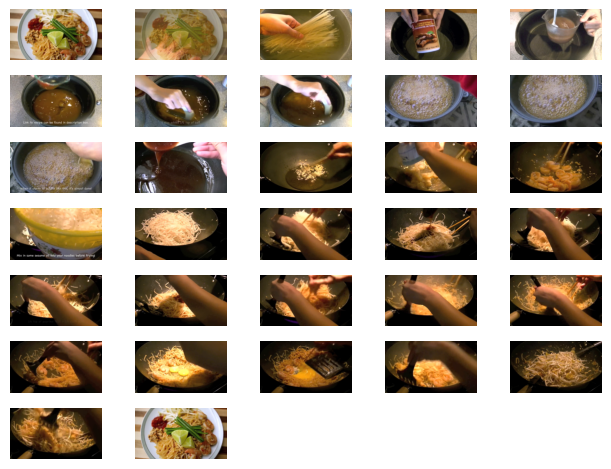

In [8]:
video, _ = load_video(
    video_path=args.video_path,
    n_frms=32,
    sampling ="uniform", return_msg = True
)
# video = vis_processor.transform(video)
print(video.size())
C, T, H, W = video.shape
ts.show(video.transpose(0, 1))

In [15]:
img_list = []
chat_state = conv_llava_llama_2.copy()
chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
msg = chat.upload_video_without_audio(
    video_path=args.video_path, 
    conv=chat_state,
    img_list=img_list, 
    n_frms=96,
)

/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [11]:
text_input_food = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. The output format of each predicted event should be like: 'start - end seconds, event description'. A specific example is : ' 90 - 102 seconds, spread margarine on two slices of white bread in the video'."
text_input_iv = "This is a medical procedural video where a lady demonstrates how to perform a medical procedure. Now imagine you are the lady performing the procedure. Describe your activities step by step based on the video content. Only provided the steps where she is actually performing the procedure. Please provide a starting timestamp and ending timestamp for each activity."
print(text_input_iv)

chat.ask(text_input_food, chat_state)

num_beams = args.num_beams
temperature = args.temperature
llm_message = chat.answer(conv=chat_state,
                          img_list=img_list,
                          num_beams=num_beams,
                          temperature=temperature,
                          max_new_tokens=300,
                          max_length=2000)[0]

print(llm_message)

This is a medical procedural video where a lady demonstrates how to perform a medical procedure. Now imagine you are the lady performing the procedure. Describe your activities step by step based on the video content. Only provided the steps where she is actually performing the procedure. Please provide a starting timestamp and ending timestamp for each activity.
0.0 - 21.5 seconds, A person stirs in a pan on a stove with cooked rice noodles in a pot of hot water.  21.5 - 47.5 seconds, A person stirs a cup of vegetables and fish in hot oil in a pan.  47.5 - 63.7 seconds, The person puts the pot of noodles on the stove and pours the vegetables and fish in.  63.7 - 83.7 seconds, The person uses a cooking fork to move the fish in the pan.  83.7 - 93.0 seconds, The person pours a egg in the pan and mixes it around.  93.0 - 168.8 seconds, The person pours in the cooked noodles in the pan.  168.8 - 188.8 seconds, The person takes the cooked noodles out of the pan and stirs the pan.  188.8 - 

In [3]:
%pip install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os

def extract_segments(segment_file, video_file, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Read segments from the text file
    with open(segment_file, 'r') as f:
        segments = f.readlines()
    
    for segment in segments:
        if segment.strip().startswith("Segment"):
            segment_parts = segment.strip().split(":")
            segment_num = segment_parts[0].split()[1]
            segment_times = segment_parts[1].split("from")[1].split("to")
            start_time = float(segment_times[0].split()[0])
            end_time = float(segment_times[1].split()[0].rstrip(')'))  # Remove ')' character

            # Extract segment from the video
            output_file = os.path.join(output_folder, f"segment_{segment_num}.mp4")
            cmd = f"ffmpeg -i {video_file} -ss {start_time} -to {end_time} -c copy {output_file}"
            os.system(cmd)

# Example usage:
segment_file = "examples/padthai_2.txt"
video_file = "examples/padthai_2.mp4"
output_folder = "segmented_videos_highlights/padthai"

extract_segments(segment_file, video_file, output_folder)


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw